In [29]:
import torch
import numpy as np
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid

In [13]:
# create a transofrm to apply to each datapoint
transform = transforms.Compose([transforms.ToTensor()])

# download the MNIST datasets
path = '~/datasets'
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset  = MNIST(path, transform=transform, download=True)

# create train and test dataloaders
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

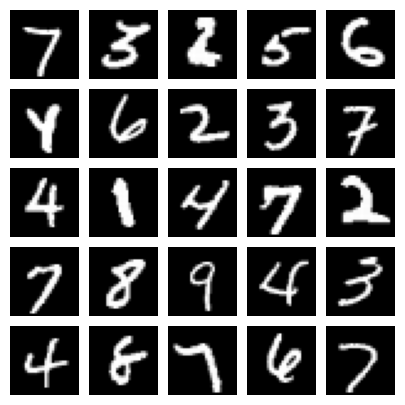

In [15]:
# get 25 sample training images for visualization
dataiter = iter(train_loader)
image = next(dataiter)

num_samples = 25
sample_images = [image[0][i,0] for i in range(num_samples)] 

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

plt.show()

In [16]:
class Encoder(nn.Module):
    
    def __init__(self, input_dim=784, hidden_dim=512, latent_dim=256):
        super(Encoder, self).__init__()

        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.mean = nn.Linear(hidden_dim, latent_dim)
        self.var = nn.Linear (hidden_dim, latent_dim)
        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.training = True
        
    def forward(self, x):
        x = self.LeakyReLU(self.linear1(x))
        x = self.LeakyReLU(self.linear2(x))

        mean = self.mean(x)
        log_var = self.var(x)                     
        return mean, log_var

In [17]:
class Decoder(nn.Module):
    
    def __init__(self, output_dim=784, hidden_dim=512, latent_dim=256):
        super(Decoder, self).__init__()

        self.linear2 = nn.Linear(latent_dim, hidden_dim)
        self.linear1 = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        x = self.LeakyReLU(self.linear2(x))
        x = self.LeakyReLU(self.linear1(x))
        
        x_hat = torch.sigmoid(self.output(x))
        return x_hat

In [18]:
class VAE(nn.Module):

    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=200, device=device):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
            )
        
        # latent mean and variance 
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)
        
        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
            )
     
    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)      
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, log_var
        
    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) 
        x_hat = self.decode(z)  
        return x_hat, mean, log_var

In [19]:
model = VAE().to(device)
optimizer = Adam(model.parameters(), lr=1e-3)

In [20]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [21]:
def train(model, optimizer, epochs, device, x_dim=784):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.view(batch_size, x_dim).to(device)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)
            
            overall_loss += loss.item()
            
            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
    return overall_loss

In [22]:
train(model, optimizer, epochs=50, device=device)

	Epoch 1 	Average Loss:  180.15215122534954
	Epoch 2 	Average Loss:  161.8650516648842
	Epoch 3 	Average Loss:  157.5291670688126
	Epoch 4 	Average Loss:  155.0058658147694
	Epoch 5 	Average Loss:  153.26599462646078
	Epoch 6 	Average Loss:  151.6719545596828
	Epoch 7 	Average Loss:  150.4991760029737
	Epoch 8 	Average Loss:  149.44166910671433
	Epoch 9 	Average Loss:  148.67859820077734
	Epoch 10 	Average Loss:  147.99317888212124
	Epoch 11 	Average Loss:  147.31288010942717
	Epoch 12 	Average Loss:  146.81623281641276
	Epoch 13 	Average Loss:  146.21313980331803
	Epoch 14 	Average Loss:  145.77859207076898
	Epoch 15 	Average Loss:  145.48997768090047
	Epoch 16 	Average Loss:  145.18021309930614
	Epoch 17 	Average Loss:  144.8955515214159
	Epoch 18 	Average Loss:  144.4267531497809
	Epoch 19 	Average Loss:  144.12463886751357
	Epoch 20 	Average Loss:  143.9061493765651
	Epoch 21 	Average Loss:  143.65623028941465
	Epoch 22 	Average Loss:  143.5175457468176
	Epoch 23 	Average Loss:  14

8377293.0146484375

In [23]:
def generate_digit(mean, var):
    z_sample = torch.tensor([[mean, var]], dtype=torch.float).to(device)
    x_decoded = model.decode(z_sample)
    digit = x_decoded.detach().cpu().reshape(28, 28) # reshape vector to 2d array
    plt.title(f'[{mean},{var}]')
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.show()

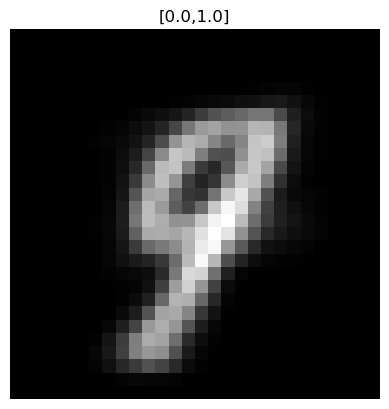

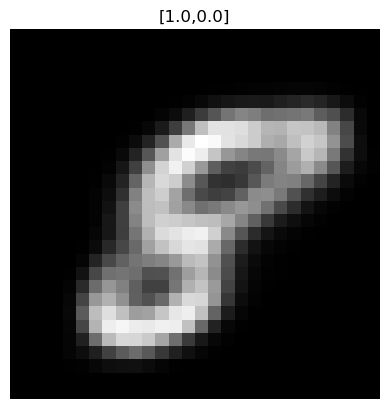

(None, None)

In [24]:
generate_digit(0.0, 1.0), generate_digit(1.0, 0.0)

In [25]:
def plot_latent_space(model, scale=5.0, n=25, digit_size=28, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid 
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()
     

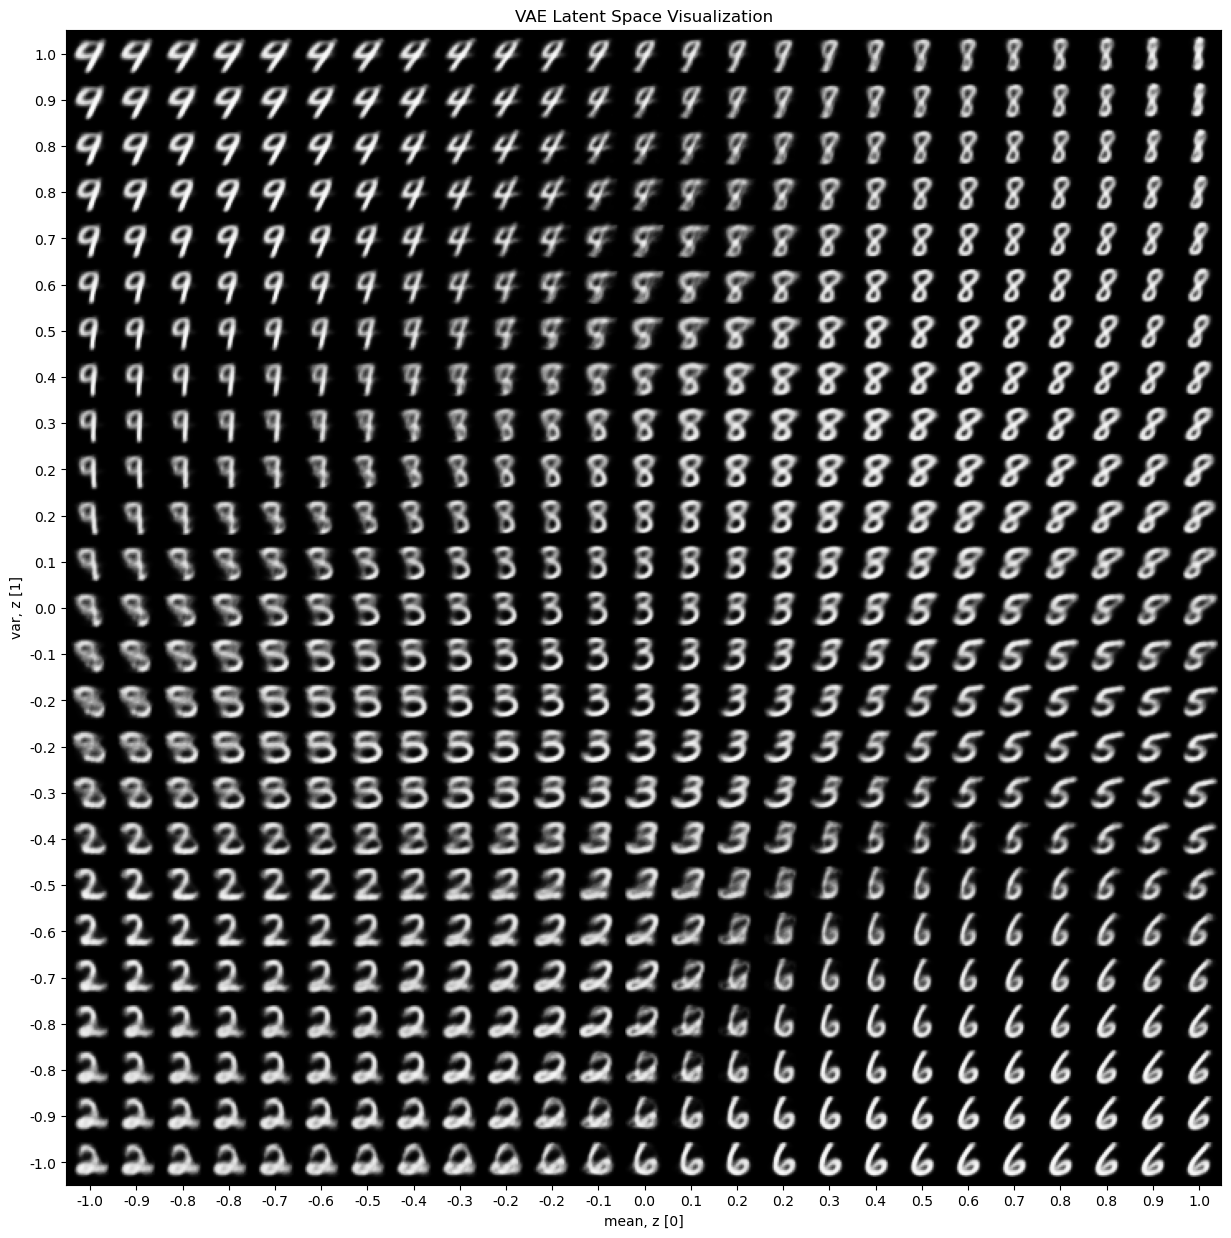

In [26]:
plot_latent_space(model, scale=1.0)

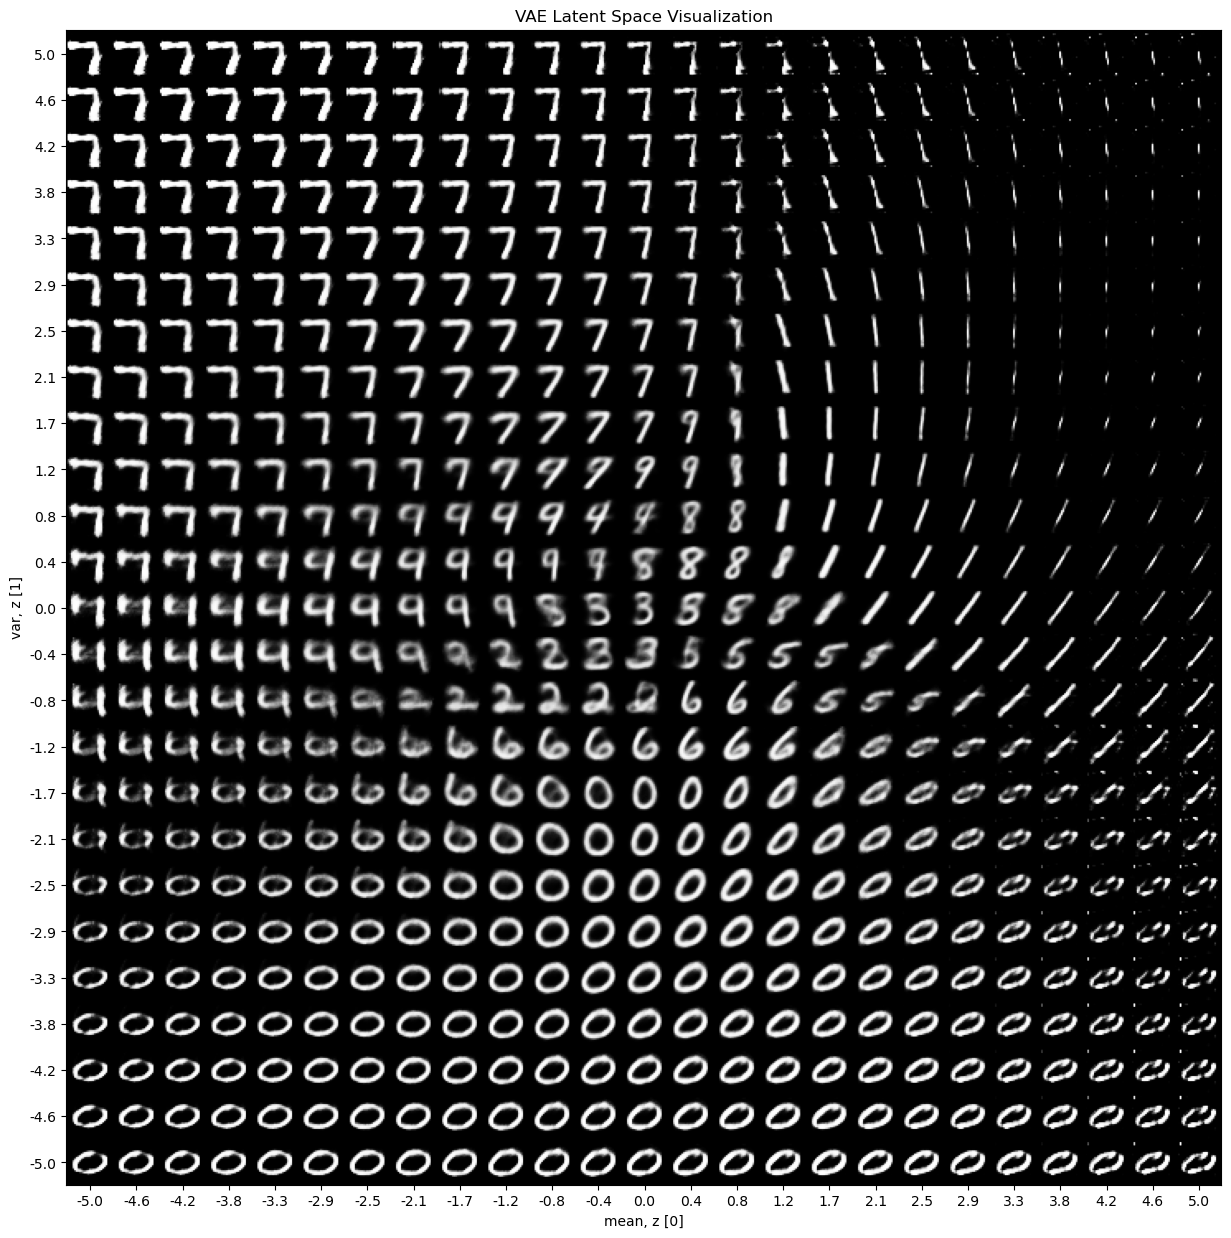

In [27]:
plot_latent_space(model, scale=5.0)

# Decoder

In [2]:
import torch
import torch.nn as nn
device = torch.device('cuda')

In [21]:
k = torch.rand(size=[50,256], device=torch.device('cuda'))
v = torch.rand(size=[50,256], device=torch.device('cuda'))
context = torch.rand(size=[1,128], device=torch.device('cuda'))

In [26]:
class MHA_Decoder(nn.Module):
    def __init__(self,
                 context_dim = 128,
                 key_dim = 256,
                 value_dim = 256,
                 num_heads = 8,
                 hidden_dim = [64, 64],
                 out_feats = 50,
                 device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
        super(MHA_Decoder, self).__init__()
        self.mha = nn.MultiheadAttention(embed_dim=context_dim,
                                         num_heads=num_heads,
                                         dropout=0.2,
                                         kdim=key_dim,
                                         vdim=value_dim)
        self.batchnorm1 = nn.BatchNorm1d(num_features=context_dim, affine=False)
        self.linear1 = nn.Linear(in_features=context_dim,
                                 out_features=hidden_dim[0])
        self.linear2 = nn.Linear(in_features=hidden_dim[0],
                                 out_features=hidden_dim[1])
        self.batchnorm2 = nn.BatchNorm1d(num_features=hidden_dim[1], affine=False)
        self.linear3 = nn.Linear(in_features=hidden_dim[1],
                                 out_features=out_feats)
        self.activation = nn.ReLU()
        self.softmax = nn.Softmax(dim=-1)
        self.device = device
        self.to(device)

    def forward(self, context, key, value):
        x, _ = self.mha(context, key, value, need_weights=False)
        # x = self.batchnorm1(x)
        x = self.activation(self.linear1(x))
        x = self.activation(self.linear2(x))
        # x = self.batchnorm2(x)
        probs = self.softmax(self.linear3(x))
        return probs

In [28]:
decoder = MHA_Decoder()
decoder(context=context, key=k, value=v).shape

torch.Size([1, 50])

In [18]:
m = nn.Softmax(dim=-1)
input = torch.randn(2, 3)
print(input)
output = m(input)
print(output)
output.shape

tensor([[ 0.0746,  1.2078, -0.3117],
        [-0.2362,  0.0563,  1.1299]])
tensor([[0.2090, 0.6490, 0.1420],
        [0.1597, 0.2140, 0.6262]])


torch.Size([2, 3])

In [12]:
ma = nn.MultiheadAttention(embed_dim=128,
                           num_heads=8,
                           dropout=0.2,
                           kdim=256,
                           vdim=256,
                           device=device)

In [13]:
out, weights = ma(context, k, v, need_weights=True)

AssertionError: was expecting embedding dimension of 128, but got 64

In [8]:
out.shape

torch.Size([1, 128])

In [10]:
weights.shape

torch.Size([1, 50])

In [1]:
import torch
from Networks.networks import *
device = torch.device('cuda')

In [7]:
n = 20
feats = 10
nodes = torch.rand(size=(n,feats), device=device)
A = torch.rand(size=(n,n,2), device=device)

cap1 = Primary_Capsule(input_dim=10, output_dim=20, activation=nn.ReLU(), k=3, edge_feat_dim = 2)
cap2 = Secondary_Capsule(input_dim=60, output_dim=30, activation=nn.ReLU(), k=3, edge_feat_dim = 2)


In [8]:
x = cap1(X=nodes, L=A)
x = cap2(X=x, L=A)

In [9]:
x.shape

torch.Size([20, 90])

In [6]:
nodes.shape

torch.Size([20, 10])

In [5]:
import torch
import numpy as np

E = np.ones(shape=(10,10,2))

In [12]:
np.sum(E[0,0,:])

2.0

In [20]:
E_hat = np.zeros_like(E)
for i in range(E.shape[0]):
    for j in range(E.shape[1]):
        for p in range(E.shape[2]):
            E_hat[i,j,p] = E[i,j,p]/np.sum(E[i,:,p])

for i in range(E.shape[0]):
    for j in range(E.shape[1]):
        for p in range(E.shape[2]):
            sum = 0
            for k in range(E.shape[1]):
                sum += E_hat[i,k,p]*E_hat[j,k,p]/np.sum(E_hat[:,k,p])
            E[i,j,p] = sum

def normalize_edges(E):
    E_hat = np.zeros_like(E)
    for i in range(E.shape[0]):
        for j in range(E.shape[1]):
            for p in range(E.shape[2]):
                E_hat[i,j,p] = E[i,j,p]/np.sum(E[i,:,p])

    for i in range(E.shape[0]):
        for j in range(E.shape[1]):
            for p in range(E.shape[2]):
                sum = 0
                for k in range(E.shape[1]):
                    sum += E_hat[i,k,p]*E_hat[j,k,p]/np.sum(E_hat[:,k,p])
                E[i,j,p] = sum
    return E

In [21]:
E = normalize_edges(np.ones(shape=(10,10,2)))
E

array([[[0.1, 0.1],
        [0.1, 0.1],
        [0.1, 0.1],
        [0.1, 0.1],
        [0.1, 0.1],
        [0.1, 0.1],
        [0.1, 0.1],
        [0.1, 0.1],
        [0.1, 0.1],
        [0.1, 0.1]],

       [[0.1, 0.1],
        [0.1, 0.1],
        [0.1, 0.1],
        [0.1, 0.1],
        [0.1, 0.1],
        [0.1, 0.1],
        [0.1, 0.1],
        [0.1, 0.1],
        [0.1, 0.1],
        [0.1, 0.1]],

       [[0.1, 0.1],
        [0.1, 0.1],
        [0.1, 0.1],
        [0.1, 0.1],
        [0.1, 0.1],
        [0.1, 0.1],
        [0.1, 0.1],
        [0.1, 0.1],
        [0.1, 0.1],
        [0.1, 0.1]],

       [[0.1, 0.1],
        [0.1, 0.1],
        [0.1, 0.1],
        [0.1, 0.1],
        [0.1, 0.1],
        [0.1, 0.1],
        [0.1, 0.1],
        [0.1, 0.1],
        [0.1, 0.1],
        [0.1, 0.1]],

       [[0.1, 0.1],
        [0.1, 0.1],
        [0.1, 0.1],
        [0.1, 0.1],
        [0.1, 0.1],
        [0.1, 0.1],
        [0.1, 0.1],
        [0.1, 0.1],
        [0.1, 0.1],
        [0.1

In [19]:
np.sum(E[2,:,0])

1.0000000000000004

In [1]:
import torch
import numpy as np
from Networks.networks import *
from Networks.utils import normalize_edges
device = torch.device('cuda')
n = 20
feats = 10
nodes = torch.rand(size=(n,feats), device=device)
E = np.random.rand(n,n,2)
E = normalize_edges(E)
E = torch.tensor(E, device=device)
# E = torch.rand(size=(n,n,2), device=device)

gnn = Laplacian_GCN(input_dim=10, output_dim=30, k=3)

# cap1 = Primary_Capsule(input_dim=10, output_dim=20, activation=nn.ReLU(), k=3)
# cap2 = Secondary_Capsule(input_dim=20, output_dim=30, activation=nn.ReLU(), k=3)

In [61]:
n = 20
feats = 10
nodes = torch.rand(size=(n,feats), device=device)
E = np.random.rand(n,n,2)
E = normalize_edges(E)
E = torch.tensor(E, device=device, dtype=torch.float32)
# E = torch.rand(size=(n,n,2), device=device)

gnn = Edge_Laplacian_GCN(input_dim=10, edge_input_dim=2, output_dim=30, k=3)

# Encoder

In [1]:
import torch
import numpy as np
from Networks.networks import *
from Networks.utils import *
device=torch.device('cuda')

n = 50
feats = 7
graph = torch.rand(size=(n, feats), device=device)
E = np.random.rand(n,n,2)
E = normalize_edges(E)
E = torch.tensor(E, device=device, dtype=torch.float32)

In [2]:
def skip_connection(X, X_):
    if  X_.dim() == 2:
        return X.repeat(1,int(X_.shape[1]/X.shape[1])) + X_
    elif X_.dim() == 3:
        return X.repeat(1,1,int(X_.shape[2]/X.shape[2])) + X_

In [4]:
linear_1 = torch.nn.Linear(in_features=feats, out_features=32, device=device)
caps1 = Primary_Capsule(input_dim=32, output_dim=32, k=2, p=3, activation=torch.nn.ReLU(), edge_feat_dim=2)
caps2 = Secondary_Capsule(input_dim=96, output_dim=96, p=3, k=2, activation=torch.nn.ReLU(), edge_feat_dim=2)
linear_2 = torch.nn.Linear(in_features=288, out_features=256, device=device)
activation = torch.nn.LeakyReLU()

In [5]:
X = linear_1(graph)
X_1 = caps1(X=X, L=E)
X_2 = caps2(X=X_1, L=E)
X = skip_connection(X_1, X_2)
X = torch.nn.BatchNorm1d(288, affine=False, device=device)(X)
X = activation(linear_2(X))

In [6]:
X.shape

torch.Size([50, 256])

In [13]:
# With Learnable Parameters
m = nn.BatchNorm1d(100)
# Without Learnable Parameters
m = nn.BatchNorm1d(100, affine=False)
input = torch.randn(20, 100)
output = m(input)
output.dim()

2

In [1]:
import torch
import numpy as np
from Networks.networks import *
from Networks.utils import *
from Models.ONR.encoder import Task_Graph_Encoder
device=torch.device('cuda')

n = 50
feats = 7
graph = torch.rand(size=(n, feats), device=device)
E = np.random.rand(n,n,2)
E = normalize_edges(E)
E = torch.tensor(E, device=device, dtype=torch.float32)

In [2]:
encoder = Task_Graph_Encoder()
encoder(X=graph, L=E).shape

torch.Size([50, 256])

# Context Generator

In [28]:
import torch
import torch.nn as nn
import numpy as np
from Networks.networks import *
from Networks.utils import *
from Models.ONR.encoder import Task_Graph_Encoder
device=torch.device('cuda')

n = 5
feats = 8
decs_idx = 2
agents = torch.rand(size=(n, feats), device=device)
time = torch.rand(size=(1,1), device=device)
idx = 2
agent = torch.unsqueeze(agents[idx,:], 0)
peers = torch.cat((agents[:idx,:],agents[idx+1:,:]), dim=0)

class Context_Encoder(nn.Module):
    def __init__(self, 
                 in_feats = 8,
                 out_feats = 128,
                 hidden_dims=[32,64],
                 device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
        super(Context_Encoder, self).__init__()
        self.agent_linear1 = nn.Linear(in_features=in_feats,
                                       out_features=hidden_dims[0])
        self.agent_linear2 = nn.Linear(in_features=hidden_dims[0],
                                       out_features=hidden_dims[1])
        self.linear1 = nn.Linear(in_features=in_feats,
                                 out_features=hidden_dims[0])
        self.linear2 = nn.Linear(in_features=hidden_dims[0],
                                 out_features=hidden_dims[1])
        self.context = nn.Linear(in_features=hidden_dims[1]*2+1,
                                 out_features=out_feats)
        self.activation = nn.ReLU()
        self.device = device
        self.to(device)

    def forward(self, agent, peers, time):
        ag_x = self.activation(self.agent_linear1(agent))
        ag_x_1 = self.activation(self.agent_linear2(ag_x))
        # skip connection
        if  ag_x_1.dim() == 2:
            ag_x_2 = ag_x.repeat(1,int(ag_x_1.shape[1]/ag_x.shape[1])) + ag_x_1
        elif ag_x_1.dim() == 3:
            ag_x_2 = ag_x.repeat(1,1,int(ag_x_1.shape[2]/ag_x.shape[2])) + ag_x_1
        
        peer_x = self.activation(self.linear1(peers))
        peer_x_1 = self.activation(self.linear2(peer_x))
        # skip connection
        if  peer_x_1.dim() == 2:
            peer_x_2 = peer_x.repeat(1,int(peer_x_1.shape[1]/peer_x.shape[1])) + peer_x_1
        elif peer_x_1.dim() == 3:
            peer_x_2 = peer_x.repeat(1,1,int(peer_x_1.shape[2]/peer_x.shape[2])) + peer_x_1
        # TODO: Potential failure point
        peer_x_2 = torch.sum(peer_x_2, dim=0, keepdim=True)
        x = self.activation(self.context(torch.cat((time, ag_x_2, peer_x_2), dim=1)))
        return x

In [29]:
print(agent.shape)
print(peers.shape)
print(time.shape)

torch.Size([1, 8])
torch.Size([4, 8])
torch.Size([1, 1])


In [30]:
context = Context_Encoder()

In [31]:
context(agent=agent, peers=peers, time=time).shape

torch.Size([1, 128])

# Testing Graph Caps conv Net

In [5]:
import torch
import torch.nn as nn

n_nodes = 100
feats = 20
batch = 200

X = torch.rand((batch, n_nodes, feats))
L = torch.rand((batch, n_nodes, n_nodes))

In [ ]:
class Laplacian_GCN(nn.Module):
    def __init__(self, input_dim, output_dim, k, activation=nn.ReLU(), device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
        super(Laplacian_GCN, self).__init__()
        self.__in_dim = input_dim
        self.__out_dim = output_dim
        self.__k = k
        self.act = activation
        self.weights = nn.ModuleList([nn.Linear(self.__in_dim, self.__out_dim, bias=False) for i in range(self.__k+1)])
        for idx, net in enumerate(self.weights):
            nn.init.xavier_uniform_(net.weight.data)
        self.device = device
        self.to(device)
    
    def forward(self, data=None, X=None, L=None):
        if X == None:
            X = data.x
            L = get_laplacian(data.edge_index)
        batch_size, num_nodes, num_features = X.shape

        if len(L.shape) == 4:
            L = L.squeeze(0)

        X_sum = torch.zeros((batch_size, num_nodes, self.__out_dim), device=self.device)
        for k in range(self.__k + 1):
            L_power_k_X = torch.matmul(torch.linalg.matrix_power(L, k), X)
            
            X_sum += self.weights[k](L_power_k_X)
        return self.act(X_sum)  

class Primary_Capsule(nn.Module):
    def __init__(self, input_dim, output_dim, latent_dim=64, gcn_model='Laplacian', p=3, k=3, device=torch.device("cuda" if torch.cuda.is_available() else "cpu"), **kwargs):
        super(Primary_Capsule, self).__init__()
        self.__in_dim = input_dim
        self.__out_dim = output_dim
        self.p = p
        self.k = k
        self.activation = kwargs['activation']
        self.device = device
        self.linear = nn.Linear(in_features=self.__in_dim, out_features=latent_dim)
        if gcn_model == 'Laplacian':
            activation = kwargs['activation']
            self.nets = nn.ModuleList([Laplacian_GCN(input_dim=latent_dim, output_dim=self.__out_dim, k=self.k, activation=activation, device=self.device) for i in range(self.p)])
        
        self.batchnorm = nn.BatchNorm1d(num_features=100)
        

    def forward(self, data=None, X=None, L=None):
        if X == None:
            X = data.x
            L = get_laplacian(data.edge_index)
        outs = []
        X = X**self.p
        for idx, net in enumerate(self.nets):
            outs.append(net(X=X, L=L))
        output = torch.stack(outs, -1)
        output = torch.flatten(output, start_dim=-2, end_dim=-1) #self.batchnorm(torch.flatten(output, -2, -1))
        return self.activation(output)